# Imports

In [55]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import sklearn.tree
import sklearn.metrics

import matplotlib.pyplot as plt
import pandas_bokeh
import sys

In [10]:
sys.path.append('..')
%reload_ext autoreload
%autoreload 2
%matplotlib inline
pandas_bokeh.output_notebook()
pd.set_option('display.max_columns', None)

Loading BokehJS ...

# Chapter 08 - Tree-Based Methods

Decision trees can be applied to both regression and classification problems. In order to make a prediction for a given observation, we typically use the *mean* or the *mode* of the training observations in the region to which it belongs. Tree-based methods are simple and useful for interpretation. However, they typically are not competitive with the best supervised learning approaches, in terms of prediction accuracy.

(Page 303). 

Predicting Baseball Players’ Salaries Using Regression Trees

(Page 304). 
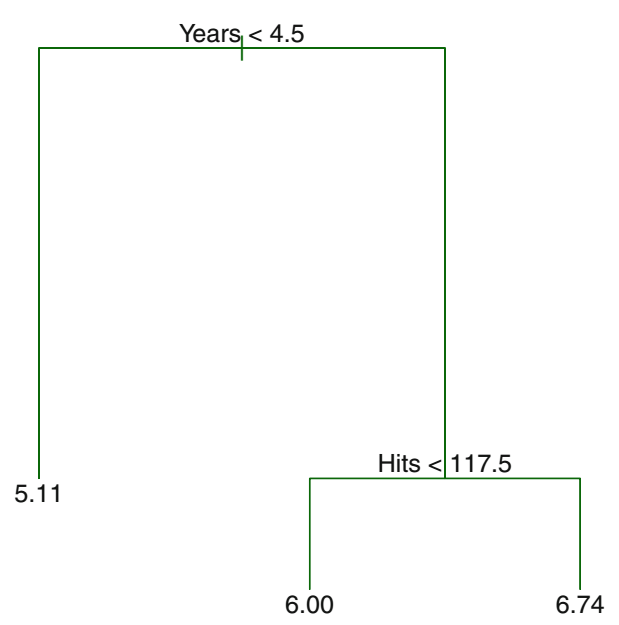

## Dataset

In [18]:
hitters = pd.read_csv("https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Hitters.csv")
hitters.head(5)

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [45]:
hitters.isnull().sum()

Unnamed: 0         0
AtBat              0
Hits               0
HmRun              0
Runs               0
RBI                0
Walks              0
Years              0
CAtBat             0
CHits              0
CHmRun             0
CRuns              0
CRBI               0
CWalks             0
League             0
Division           0
PutOuts            0
Assists            0
Errors             0
Salary            59
NewLeague          0
SalaryQuantile    59
LogSalary         59
dtype: int64

In [46]:
hitters['Salary'] = hitters['Salary'].apply(pd.to_numeric, errors='coerce')
hitters['Salary']  = hitters['Salary'] .fillna(hitters['Salary'] .median())  # works

In [47]:
hitters['SalaryQuantile'] = pd.qcut(hitters['Salary'], 4, labels=['Low', 'Average', 'High', 'Very High'])
hitters['LogSalary'] = hitters['Salary'].apply(np.log)

In [48]:
hitters.plot_bokeh(
    kind='scatter',
    x='Years',
    y='Hits',
    xlabel='Years',
    category="LogSalary",
    ylabel='Hits',
    figsize=(1200, 800),
    title='Salary by hits and years played'
)    

Figure(id='4781', ...)

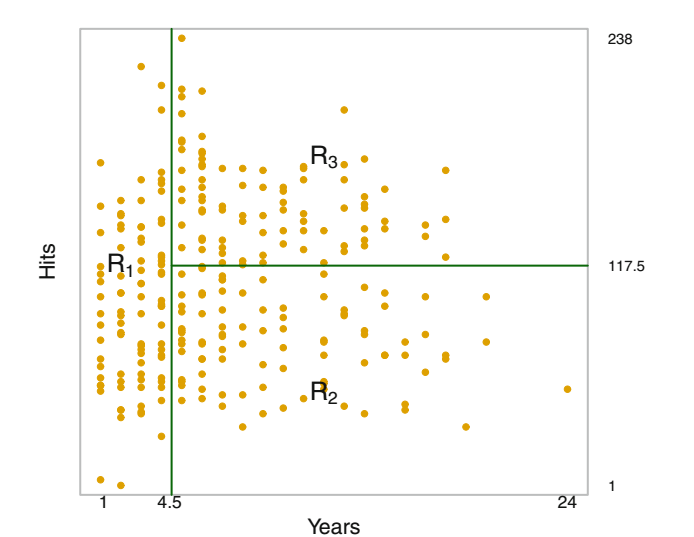

The goal is to find boxes R1,...,RJ that minimize the RSS, given by

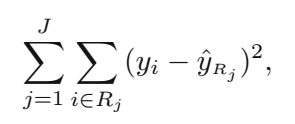


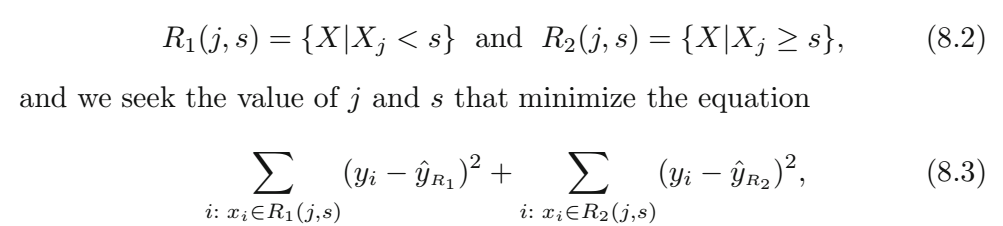
(Page 306). 


Tree Pruning
---
The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits (that is, fewer regions R1,...,RJ ) might lead to lower variance and better interpretation at the cost of a little bias.

(Page 307). 

Visualising a tree and its boxes

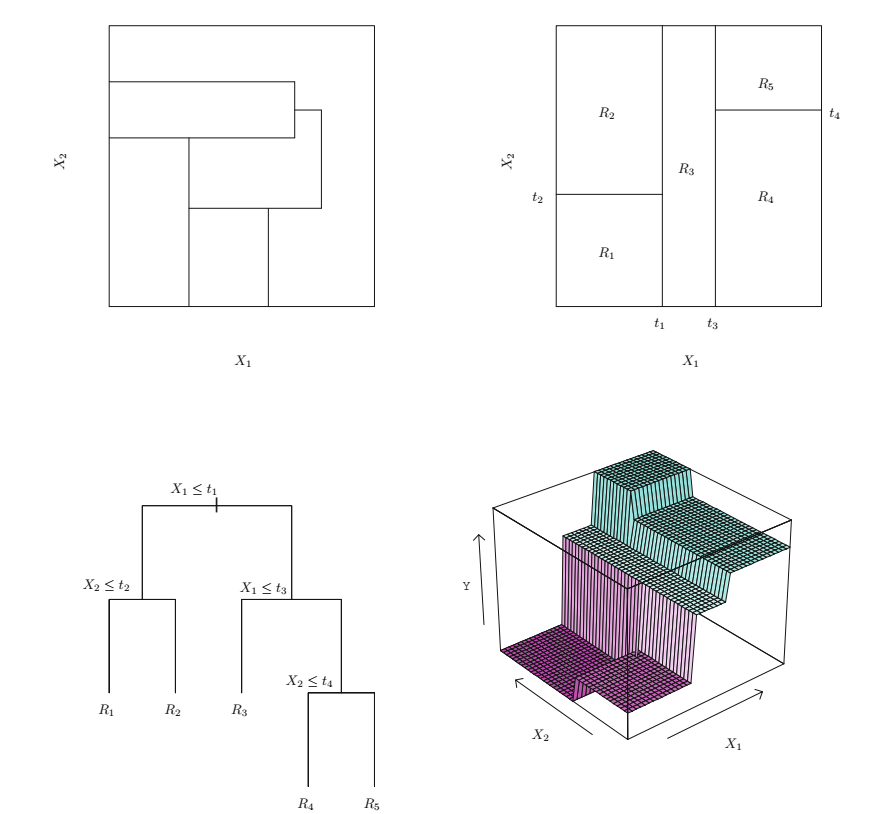

## Modeling a tree

In [82]:
x_train, x_test, y_train, y_test = train_test_split(hitters[['Years', 'Hits']], hitters['Salary'], test_size=0.25, random_state=2)

In [83]:
dt = DecisionTreeRegressor(max_depth=2, )
dt.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [84]:
x_test['y_predict'] = dt.predict(x_test)
x_test['y_true'] = y_test

In [85]:
sklearn.metrics.mean_squared_error(x_test['y_true'], x_test['y_predict'] )

101309.5979122468

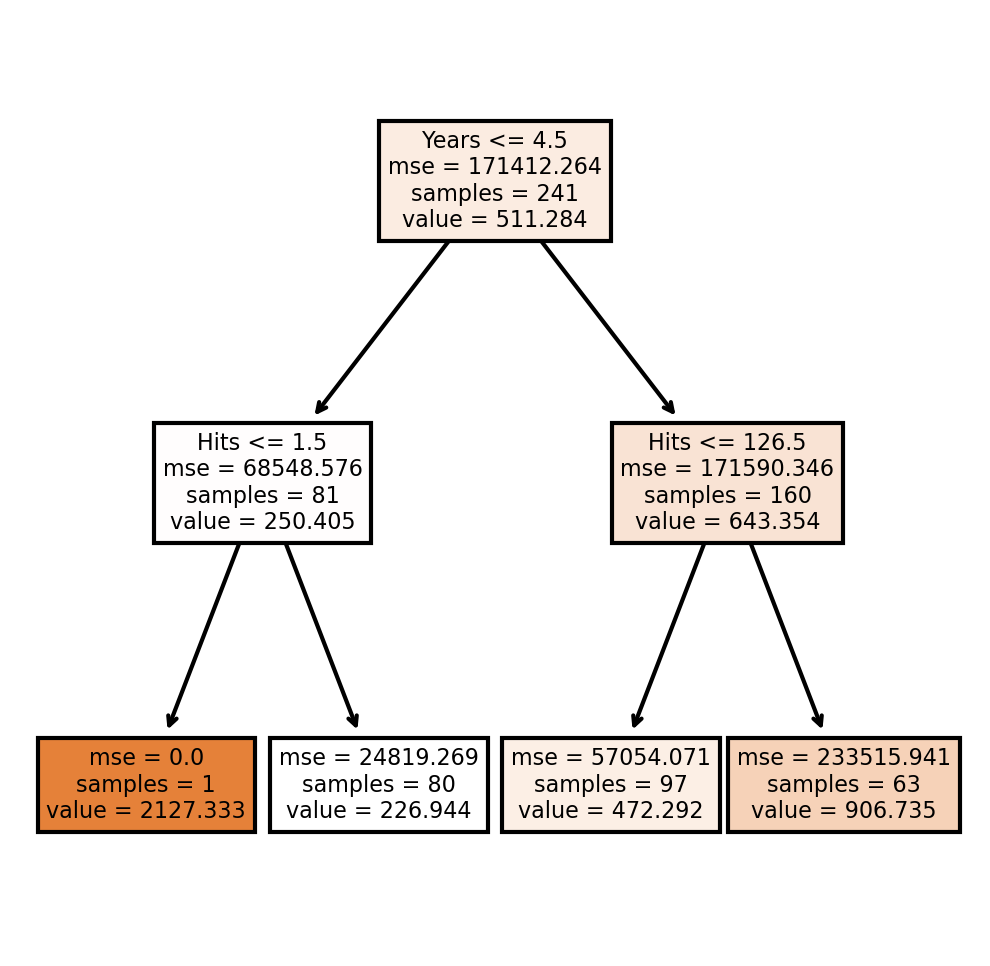

In [86]:
fn=x_train.columns.to_list()
cn=y_train
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
sklearn.tree.plot_tree(dt,
               feature_names = fn, 
               class_names=cn,
               filled = True);

### dtreeviz package and others

https://explained.ai/decision-tree-viz/index.html

https://github.com/parrt/dtreeviz

In [87]:
from dtreeviz.trees import *

In [ ]:
viz = dtreeviz(dt,
               x_train,
               y_train,
               target_name='Salary',
               feature_names=x_train.columns.to_list())
              
viz.view()  

## Classification Trees

A natural alternative to RSS is the classification error rate. Since we plan classification to assign an observation in a given region to the most commonly occurring error rate class of training observations in that region, the classification error rate is simply the fraction of the training observations in that region that do not belong to the most common class:

(Page 311).  
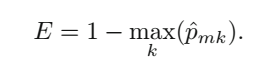

Here ˆpmk represents the proportion of training observations in the mth region that are from the kth class. However, it turns out that classification error is not sufficiently sensitive for tree-growing, and in practice two other measures are preferable. The Gini index is defined by

(Page 312). 

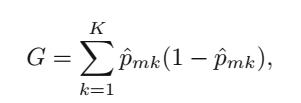

a measure of total variance across the K classes. It is not hard to see that the Gini index takes on a small value if all of the ˆpmk’s are close to zero or one. For this reason the Gini index is referred to as a measure of node purity—a small value indicates that a node contains predominantly observations from a single class. entropy are typically used to evaluate the quality of a particular split, since these two approaches are more sensitive to node purity than is the classification error rate. Any of these three approaches might be used when pruning the tree, but the classification error rate is preferable if prediction accuracy of the final pruned tree is the goal. Figure 8.6 shows an example on the Heart data set. These data contain a binary outcome HD for 303 patients who presented with chest pain. An outcome value of Yes indicates the presence of heart disease based on an angiographic test, while No means no heart disease. There are 13 predictors including Age, Sex, Chol (a cholesterol measurement), and other heart and lung function measurements. Cross-validation results in a tree with six terminal nodes. In our discussion thus far, we have assumed that the predictor variables take on continuous values. However, decision trees can be constructed even in the presence of qualitative predictor variables. For instance, in the Heart data, some of the predictors, such as Sex, Thal (Thallium stress test), and ChestPain, are qualitative. Therefore, a split on one of these variables amounts to assigning some of the qualitative values to one branch and An alternative to the Gini index is entropy, given by

(Page 312). 

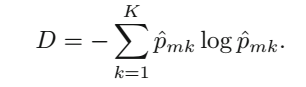

Since 0 ≤ pˆmk ≤ 1, it follows that 0 ≤ −pˆmk log ˆpmk. One can show that the entropy will take on a value near zero if the pˆmk’s are all near zero or near one.

(Page 312). 

### Classification Tree Modelling

In [110]:
heart = pd.read_csv("../../data/raw/heart.csv")
heart.head(5)

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [111]:
heart.isnull().sum()

Unnamed: 0    0
Age           0
Sex           0
ChestPain     0
RestBP        0
Chol          0
Fbs           0
RestECG       0
MaxHR         0
ExAng         0
Oldpeak       0
Slope         0
Ca            4
Thal          2
AHD           0
dtype: int64

In [112]:
heart.dropna(inplace=True)
heart['class'] = np.where(heart['AHD']=='Yes', 1, 0)

In [113]:
x_train, x_test, y_train, y_test = train_test_split(heart[['Age','Sex','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope','Ca']], heart['class'], test_size=0.25, random_state=2)

In [114]:
dt = DecisionTreeClassifier(max_depth=2, )
dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [115]:
x_test['y_predict'] = dt.predict(x_test)
x_test['y_true'] = y_test

In [116]:
sklearn.metrics.accuracy_score(x_test['y_true'], x_test['y_predict'] )

0.7466666666666667

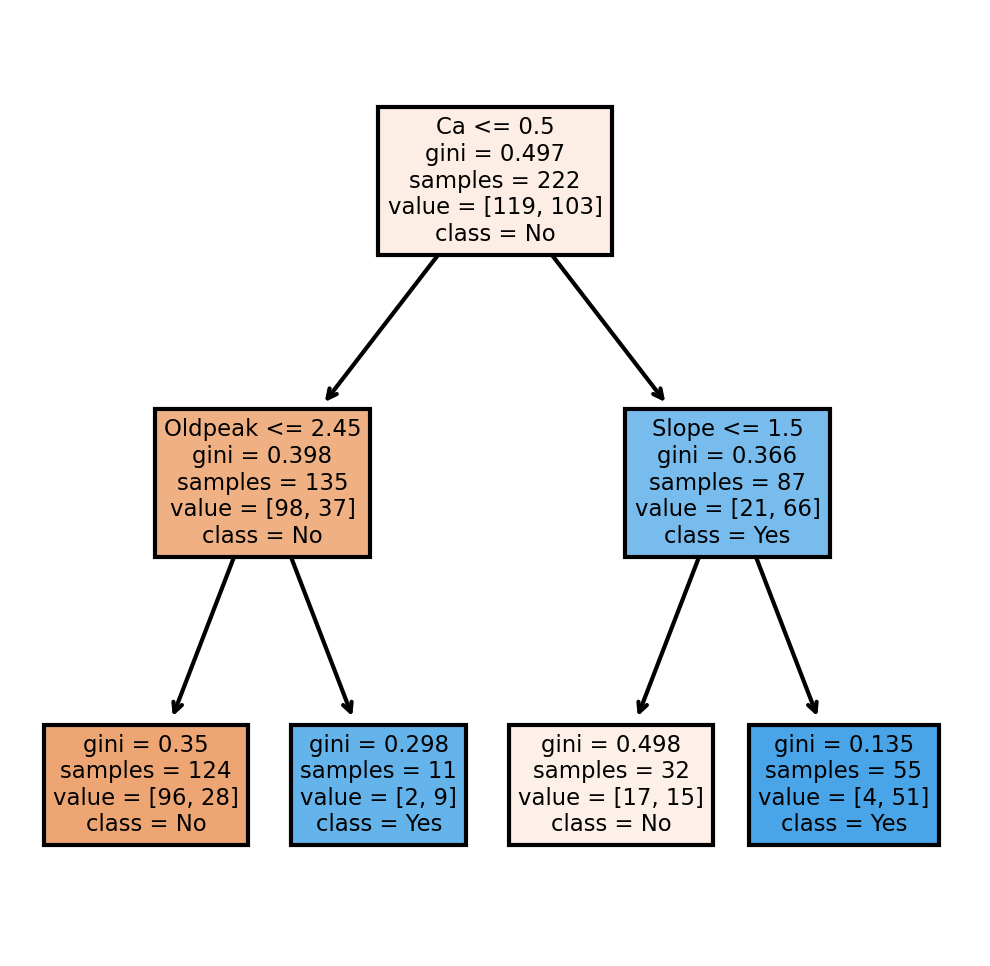

In [122]:
fn=x_train.columns.to_list()
cn=y_train
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
sklearn.tree.plot_tree(dt,
               feature_names = fn, 
               class_names=heart['AHD'],
               filled = True);

### Linear Models vs Tree Models

Regression and classification trees have a very different flavor from the more classical approaches for regression and classification presented in Chapters 3 and 4. In particular, linear regression assumes a model of the form

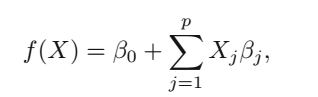


whereas regression trees assume a model of the form 

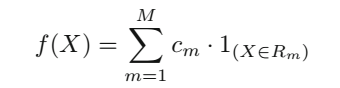

where R1,...,RM represent a partition of feature space.

(Page 314). 

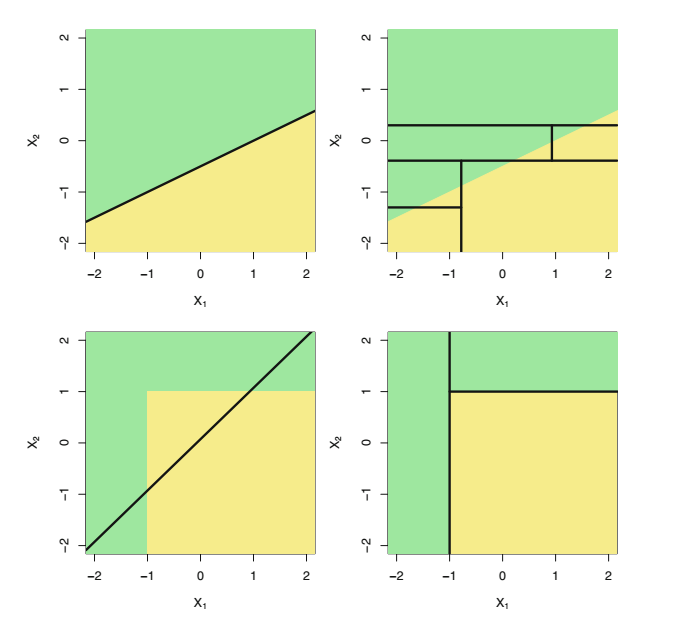

## Advantages and Disadvantages of Trees
Decision trees for regression and classification have a number of advantages over the more classical approaches seen in Chapters 3 and 4:

Advantages
---
* Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!
* Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches seen in previous chapters.
* Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small).
* Trees can easily handle qualitative predictors without the need to create dummy variables.

Disadvantages
---
* Unfortunately, trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches seen in this book.
* Additionally, trees can be very non-robust. In other words, a small change in the data can cause a large change in the final estimated tree.

However, by aggregating many decision trees, using methods like bagging, random forests, and boosting, the predictive performance of trees can be substantially improved.

(Page 315, 316). 

## Bagging

Recall that given a set of n independent observations Z1,...,Zn, each with variance σ2, the variance of the mean Z¯ of the observations is given by σ2/n. In other words, averaging a set of observations reduces variance.

(Page 316). 

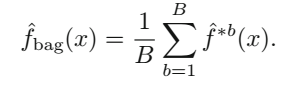

### Random Forests

Random forests provide an improvement over bagged trees by way of a random small tweak that decorrelates the trees.
A fresh sample of m predictors is taken at each split, and typically we choose m ≈ √p—that is, the number of predictors considered at each split is approximately equal to the square root of the total number of predictors

(Page 319). 

### Feature Importance
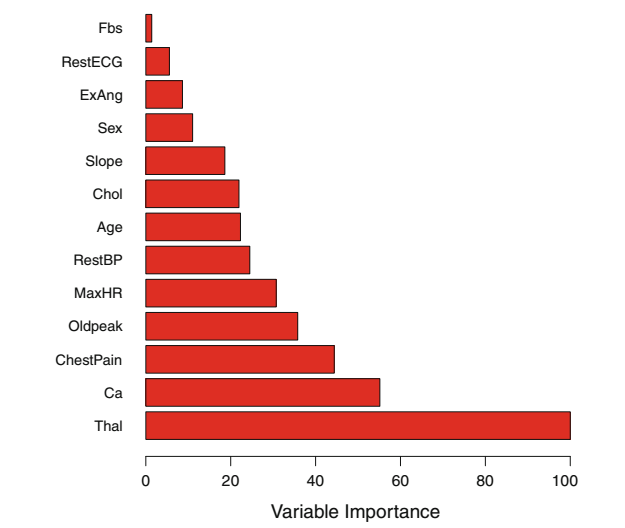

## Boosting

Like bagging, boosting is a general approach that can be applied to many statistical learning methods for regression or classification. Here we restrict our discussion of boosting to the context of decision trees.

What is the idea behind this procedure? Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly. Given the current model, we fit a decision tree to the residuals from the model. That is, we fit a tree using the current residuals, rather than the outcome Y

(Page 321). 

### Gradient Boosting Machines